In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from matplotlib.ticker import ScalarFormatter
import mplfinance as mpf
from PIL import Image

In [2]:
df_img_list = pd.read_csv('train_image_level.csv')

In [3]:
df_img_list.head(2)

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed


In [4]:
df_img_list['img_path'] = 'train/' + df_img_list['id'].replace('_image', '', regex=True) + '.jpg'
df_img_list['bin_label'] = df_img_list['boxes'].notna().astype(int)

In [5]:
df_img_list.head(2)

,id,boxes,label,StudyInstanceUID,img_path,bin_label
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,train/000a312787f2.jpg,1
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,train/000c3a3f293f.jpg,0


In [6]:
df = df_img_list[['id', 'img_path', 'bin_label']].copy()

In [7]:
df

,id,img_path,bin_label
0,000a312787f2_image,train/000a312787f2.jpg,1
1,000c3a3f293f_image,train/000c3a3f293f.jpg,0
2,0012ff7358bc_image,train/0012ff7358bc.jpg,1
3,001398f4ff4f_image,train/001398f4ff4f.jpg,1
4,001bd15d1891_image,train/001bd15d1891.jpg,1
...,...,...,...
6329,ffcc6edd9445_image,train/ffcc6edd9445.jpg,0
6330,ffd91a2c4ca0_image,train/ffd91a2c4ca0.jpg,0
6331,ffd9b6cf2961_image,train/ffd9b6cf2961.jpg,1
6332,ffdc682f7680_image,train/ffdc682f7680.jpg,1


In [8]:
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from scipy import stats

mean_list = []
min_list = []
q1_list = []
median_list = []
q3_list = []
max_list = []
mode_list = []
var_list = []
std_list = []
cv_list = []
iqr_list = []

for path in tqdm(df['img_path']):
    img = Image.open(path).convert('L')
    arr = np.array(img).flatten().astype(np.float32)  

    mean = arr.mean()
    std = arr.std()
    var = arr.var()
    q1 = np.percentile(arr, 25)
    median = np.median(arr)
    q3 = np.percentile(arr, 75)
    iqr = q3 - q1
    min_val = arr.min()
    max_val = arr.max()
    mode = stats.mode(arr, keepdims=False).mode
    cv = std / mean if mean != 0 else 0

    mean_list.append(mean)
    min_list.append(min_val)
    q1_list.append(q1)
    median_list.append(median)
    q3_list.append(q3)
    max_list.append(max_val)
    mode_list.append(mode)
    var_list.append(var)
    std_list.append(std)
    cv_list.append(cv)
    iqr_list.append(iqr)

df['Mean'] = mean_list
df['Min'] = min_list
df['Q1'] = q1_list
df['Median'] = median_list
df['Q3'] = q3_list
df['Max'] = max_list
df['Mode'] = mode_list
df['Var'] = var_list
df['SD'] = std_list
df['CV'] = cv_list
df['IQR'] = iqr_list


100%|██████████| 6334/6334 [00:15<00:00, 404.68it/s]


In [9]:
df

,id,img_path,bin_label,Mean,Min,Q1,Median,Q3,Max,Mode,Var,SD,CV,IQR
0,000a312787f2_image,train/000a312787f2.jpg,1,128.671219,0.0,87.0,135.0,192.0,255.0,2.0,4594.478027,67.782578,0.526789,105.0
1,000c3a3f293f_image,train/000c3a3f293f.jpg,0,161.156876,0.0,119.0,173.0,199.0,250.0,186.0,2483.795410,49.837692,0.309250,80.0
2,0012ff7358bc_image,train/0012ff7358bc.jpg,1,106.971786,0.0,72.0,106.0,148.0,255.0,106.0,2607.826660,51.066883,0.477386,76.0
3,001398f4ff4f_image,train/001398f4ff4f.jpg,1,120.719391,0.0,38.0,127.0,195.0,255.0,0.0,7195.341309,84.825356,0.702666,157.0
4,001bd15d1891_image,train/001bd15d1891.jpg,1,100.022202,0.0,86.0,106.0,121.0,146.0,107.0,849.666138,29.149033,0.291426,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445_image,train/ffcc6edd9445.jpg,0,132.930649,0.0,79.0,133.0,196.0,247.0,0.0,4435.089355,66.596466,0.500987,117.0
6330,ffd91a2c4ca0_image,train/ffd91a2c4ca0.jpg,0,105.768494,0.0,92.0,107.0,121.0,149.0,110.0,510.966858,22.604576,0.213717,29.0
6331,ffd9b6cf2961_image,train/ffd9b6cf2961.jpg,1,111.360992,0.0,61.0,119.0,160.0,250.0,0.0,3814.473633,61.761425,0.554606,99.0
6332,ffdc682f7680_image,train/ffdc682f7680.jpg,1,146.238953,0.0,121.0,171.0,186.0,255.0,0.0,3451.235840,58.747219,0.401721,65.0


In [10]:
import numpy as np
from PIL import Image
from skimage.util import view_as_blocks

def compute_cluster_feature(img_path, patch_size=16):
    img = Image.open(img_path).convert("L") 
    img = img.resize((256, 256))
    img_np = np.array(img)

    blocks = view_as_blocks(img_np, block_shape=(patch_size, patch_size))
    means = blocks.mean(axis=(2, 3)) 
    return means.flatten()

In [11]:
df['cluster_feature'] = df['img_path'].apply(compute_cluster_feature)


In [12]:
df

,id,img_path,bin_label,Mean,Min,Q1,Median,Q3,Max,Mode,Var,SD,CV,IQR,cluster_feature
0,000a312787f2_image,train/000a312787f2.jpg,1,128.671219,0.0,87.0,135.0,192.0,255.0,2.0,4594.478027,67.782578,0.526789,105.0,"[20.99609375, 24.03515625, 59.0078125, 62.9843..."
1,000c3a3f293f_image,train/000c3a3f293f.jpg,0,161.156876,0.0,119.0,173.0,199.0,250.0,186.0,2483.795410,49.837692,0.309250,80.0,"[117.23046875, 122.7421875, 175.01171875, 181...."
2,0012ff7358bc_image,train/0012ff7358bc.jpg,1,106.971786,0.0,72.0,106.0,148.0,255.0,106.0,2607.826660,51.066883,0.477386,76.0,"[1.51171875, 12.75390625, 48.71875, 71.0, 56.5..."
3,001398f4ff4f_image,train/001398f4ff4f.jpg,1,120.719391,0.0,38.0,127.0,195.0,255.0,0.0,7195.341309,84.825356,0.702666,157.0,"[15.01171875, 28.328125, 1.0234375, 0.0, 0.519..."
4,001bd15d1891_image,train/001bd15d1891.jpg,1,100.022202,0.0,86.0,106.0,121.0,146.0,107.0,849.666138,29.149033,0.291426,35.0,"[24.27734375, 22.5, 21.28125, 21.03125, 20.281..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6329,ffcc6edd9445_image,train/ffcc6edd9445.jpg,0,132.930649,0.0,79.0,133.0,196.0,247.0,0.0,4435.089355,66.596466,0.500987,117.0,"[56.5078125, 64.75, 67.515625, 65.23046875, 58..."
6330,ffd91a2c4ca0_image,train/ffd91a2c4ca0.jpg,0,105.768494,0.0,92.0,107.0,121.0,149.0,110.0,510.966858,22.604576,0.213717,29.0,"[67.46875, 105.49609375, 98.015625, 100.742187..."
6331,ffd9b6cf2961_image,train/ffd9b6cf2961.jpg,1,111.360992,0.0,61.0,119.0,160.0,250.0,0.0,3814.473633,61.761425,0.554606,99.0,"[3.15234375, 17.84765625, 39.625, 62.3671875, ..."
6332,ffdc682f7680_image,train/ffdc682f7680.jpg,1,146.238953,0.0,121.0,171.0,186.0,255.0,0.0,3451.235840,58.747219,0.401721,65.0,"[7.140625, 91.02734375, 152.75, 160.98828125, ..."


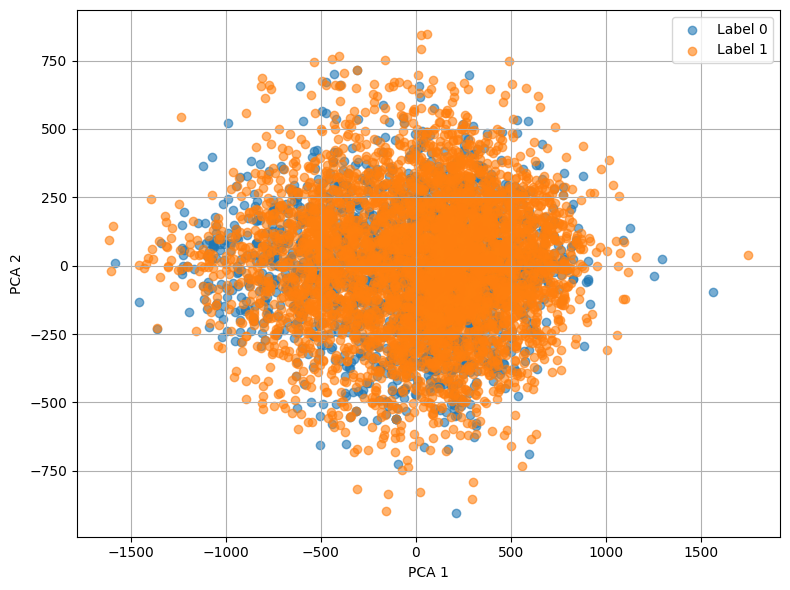

In [13]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = np.vstack(df['cluster_feature'].values)  
y = df['bin_label'].values  

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    idx = y == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Label {label}', alpha=0.6)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

X = np.vstack(df['cluster_feature'].values)  

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


ari = adjusted_rand_score(df['bin_label'], cluster_labels)
print(f"{ari:.4f}")

0.0032


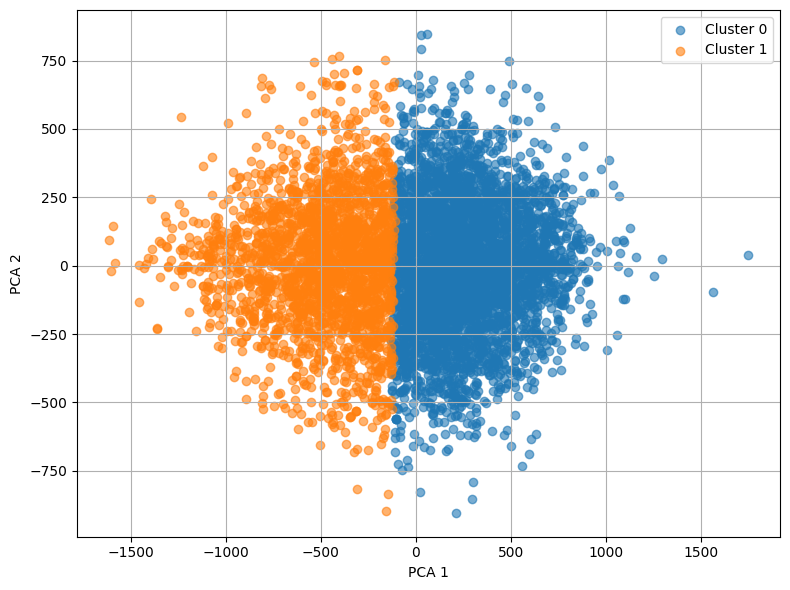

In [20]:
plt.figure(figsize=(8, 6))
for label in np.unique(cluster_labels):
    idx = cluster_labels == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Cluster {label}', alpha=0.6)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
from sklearn.cluster import SpectralClustering

X = np.vstack(df['cluster_feature'].values)
spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
cluster_labels = spectral.fit_predict(X)

df['spectral_cluster'] = cluster_labels
ari = adjusted_rand_score(df['bin_label'], cluster_labels)
print(f"{ari:.4f}")


0.0021


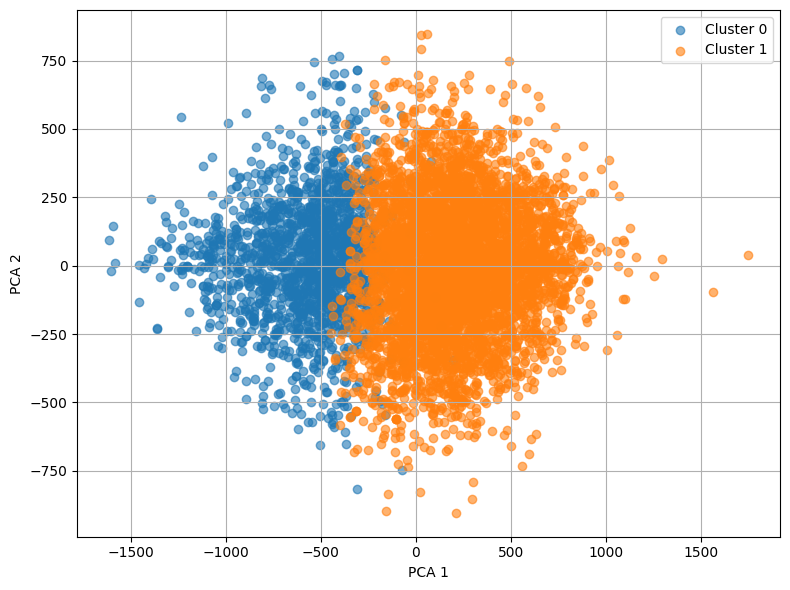

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in np.unique(cluster_labels):
    idx = cluster_labels == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Cluster {label}', alpha=0.6)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
from sklearn.mixture import GaussianMixture

X = np.vstack(df['cluster_feature'].values)
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X)  # X là dữ liệu đầu vào

df['gmm_cluster'] = gmm_labels
ari = adjusted_rand_score(df['bin_label'], gmm_labels)
print(f"{ari:.4f}")


-0.0038


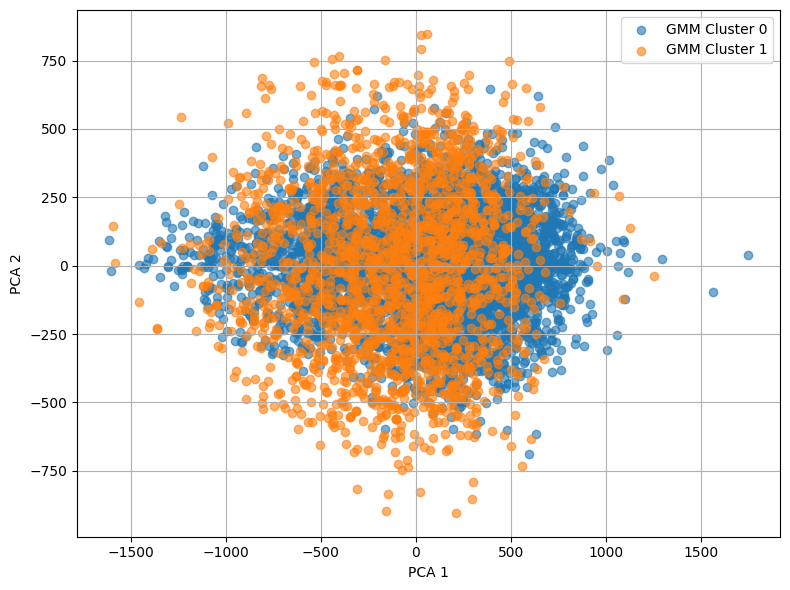

In [18]:
X_pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(8, 6))
for label in np.unique(gmm_labels):
    idx = gmm_labels == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'GMM Cluster {label}', alpha=0.6)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
